** Rough Draft of Neuromancer UTIntegrator and sigma points / inverse sigma points Nodes**

## Data

Refer to `simulators.py` and `datasets.py` to generate time-series datasets of moments and create sigma points dataset. These are for PyTorch, however. Trying to find a way to handle these in Neuromancer. 

To be able to showcase the SPINODE method on existing Neuromancer examples below is a code to run PSL systems, generate Monte Carlo simulations, and then add moments initial condition and rollout to the DictDataset. 

In [19]:
import numpy as np
import torch
from torch.utils.data import DataLoader

# ---- Euler-Murayama step for generic ODE_Autonomous drift: x_{k+1} = x_k + f(x_k,t_k)*dt + sigma*sqrt(dt)*eta ----
def em_rollout_system(sys, T, dt, sigma=0.0, x0=None, seed=None):
    """
    sys: an instance of ODE_Autonomous (from neuromancer.psl.base)
    T:   number of integration steps
    dt:  time step
    sigma: scalar noise std (additive, isotropic); 0 => deterministic
    x0:  initial state (1D array, length nx). If None, uses sys default x0.
    returns: ndarray [T+1, nx]
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    # use system's default initial condition if not provided
    if x0 is None:
        # sys.params defines variables/constants/parameters; variables['x0'] is default init
        x0 = np.array(sys.x0, dtype=float)
    else:
        x0 = np.array(x0, dtype=float)

    nx = x0.size
    X = np.zeros((T+1, nx), dtype=float)
    X[0] = x0

    # EM time loop
    t = 0.0
    for k in range(T):
        # drift f(x,t) via the system's equations
        f_list = sys.equations(t, X[k])        # returns list of derivatives
        f = np.array(f_list, dtype=float)       # [nx]
        # additive noise
        noise = sigma * np.sqrt(dt) * rng.standard_normal(size=nx)
        # EM update
        X[k+1] = X[k] + f*dt + noise
        t += dt
    return X

from torch.utils.data import Dataset, default_collate
import torch

from torch.utils.data import Dataset, default_collate
import torch

class DictDataset4D(Dataset):
    def __init__(self, arrays: dict, name='dataset'):
        super().__init__()
        self.arrays = {k: torch.as_tensor(v).float() for k, v in arrays.items()}
        lens = [v.shape[0] for v in self.arrays.values()]
        assert len(set(lens)) == 1, "Mismatched batch dimension."
        self.N = lens[0]
        self.name = name

    def __len__(self): return self.N
    def __getitem__(self, idx): return {k: v[idx] for k, v in self.arrays.items()}

    # Note: this collate_fn is only used if you pass THIS dataset to DataLoader
    def collate_fn(self, batch):
        batch = default_collate(batch)
        batch['name'] = self.name
        return batch
    


def get_mc_data(system_class,
                nsteps_total: int,
                nsteps_per_batch: int,
                dt: float,
                batch_size: int,
                nx: int = None,
                experiments: int = 64,
                sigma: float = 0.05,
                x0_sampler=None,
                seed: int = 0):
    """
    Build train/dev/test with a 4-D array: [B, T, nx, E]
      - system_class: one of your systems (e.g., VanDerPol)
      - nsteps_total: total rollout length to generate per split
      - nsteps_per_batch: T for each batch item (segment length)
      - dt: time step
      - batch_size: DataLoader batch size
      - experiments: E (number of MC particles per segment)
      - sigma: additive noise std for EM
      - x0_sampler: function (E)-> array [E, nx] for initial states; default = system default, jittered
      - seed: RNG seed

    Returns:
      train_loader, dev_loader, test_data (dict with X: [1, nsteps_total, nx, E], x0)
    """
    rng = np.random.default_rng(seed)

    # instantiate the system
    sys = system_class()
    if nx is None:
        nx = len(np.array(sys.x0, dtype=float))

    # default x0 sampler: jitter around system's default
    if x0_sampler is None:
        def x0_sampler(E):
            base = np.array(sys.x0, dtype=float)
            jitter = 0.05 * rng.standard_normal(size=(E, nx))
            return base[None, :] + jitter

    # --- helper: ensemble rollout to [T+1, nx, E] ---
    def ensemble_rollout(T, E):
        X_all = np.zeros((T+1, nx, E), dtype=float)
        X0s = x0_sampler(E)                              # [E, nx]
        for e in range(E):
            Xi = em_rollout_system(sys, T=T, dt=dt, sigma=sigma, x0=X0s[e], seed=rng.integers(1<<30))
            X_all[:, :, e] = Xi
        return X0s, X_all

    # --- make three splits ---
    def make_split(nsteps_total, name='split'):
        X0s, X_all = ensemble_rollout(T=nsteps_total, E=experiments)  # X_all: [T+1, nx, E]
        # chop into batches of length nsteps_per_batch
        T_full = nsteps_total
        nbatch = T_full // nsteps_per_batch
        T_used = nbatch * nsteps_per_batch

        # reshape: [B, T, nx, E]
        X_used = X_all[:T_used+1]  # keep one extra for convenience if needed
        # we’ll use non-overlapping windows [k:k+T]
        X_batches = []
        x0_batches = []
        for b in range(nbatch):
            start = b * nsteps_per_batch
            stop  = start + nsteps_per_batch
            Xb = X_used[start:stop]             # [T, nx, E]
            x0b = X_used[start:start+1]         # [1, nx, E]
            X_batches.append(np.transpose(Xb, (0,1,2)))     # keep as [T, nx, E]
            x0_batches.append(np.transpose(x0b, (0,1,2)))   # [1, nx, E]

        X_arr  = np.stack(X_batches,  axis=0)   # [B, T, nx, E]
        x0_arr = np.stack(x0_batches, axis=0)   # [B, 1, nx, E]

        data = DictDataset4D({'X': X_arr, 'x0': x0_arr}, name=name)
        loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                            collate_fn=DictDataset4D.collate_fn)
        return data

    # Train / Dev / Test (independent draws by changing seed streams)
    train_data = make_split(nsteps_total, name='train')
    dev_data = make_split(nsteps_total, name='dev')
    

    return train_data, dev_data



In [20]:
# Example: build a 4-D MC dataset for VanDerPol
from types import SimpleNamespace

from neuromancer import psl
system = psl.systems['VanDerPol']

# Assume your VanDerPol class above is imported
train_data, dev_data = get_mc_data(
    system_class=system,
    nsteps_total=2000,      # total steps per split
    nsteps_per_batch=2,   # window length T
    dt=0.01,
    batch_size=16,
    experiments=256,         # E particles
    sigma=0.2,             # additive noise
    seed=42
)


### Add wrapper to add mean and variance i.c. and rollout for that batch (across experiments)

In [21]:
from torch.utils.data import Dataset

class WithStats4D(Dataset):
    def __init__(self, base_ds, exp_dim: int = -1, unbiased: bool = False):
        self.base = base_ds
        self.exp_dim = exp_dim
        self.unbiased = unbiased
        self.name = getattr(base_ds, "name", "unnamed")

    def __len__(self): return len(self.base)

    def __getitem__(self, idx):
        b = self.base[idx]              # {'X': [T,nx,E], 'x0': [1,nx,E], ...}
        X, x0 = b["X"], b["x0"]

        mu   = X.mean(dim=self.exp_dim)
        var  = X.var(dim=self.exp_dim, unbiased=self.unbiased)
        mu0  = x0.mean(dim=self.exp_dim)
        var0 = x0.var(dim=self.exp_dim, unbiased=self.unbiased)

        out = dict(b)
        out["mu"], out["var"]   = mu, var
        out["mu0"], out["var0"] = mu0, var0
        # DO NOT put 'name' here per-sample
        return out

    # Provide a collate_fn so batches get a single string, not a list
    def collate_fn(self, batch):
        batch = default_collate(batch)
        batch['name'] = self.name
        return batch        
 

# Example:
wrapped_train = WithStats4D(train_data, exp_dim=-1, unbiased=False)
train_loader = DataLoader(wrapped_train, batch_size=16, shuffle=False, collate_fn=wrapped_train.collate_fn)
for b in train_loader:
    print(b["mu"].shape, b["var"].shape)


torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size([16, 2, 2])
torch.Size([16, 2, 2]) torch.Size(

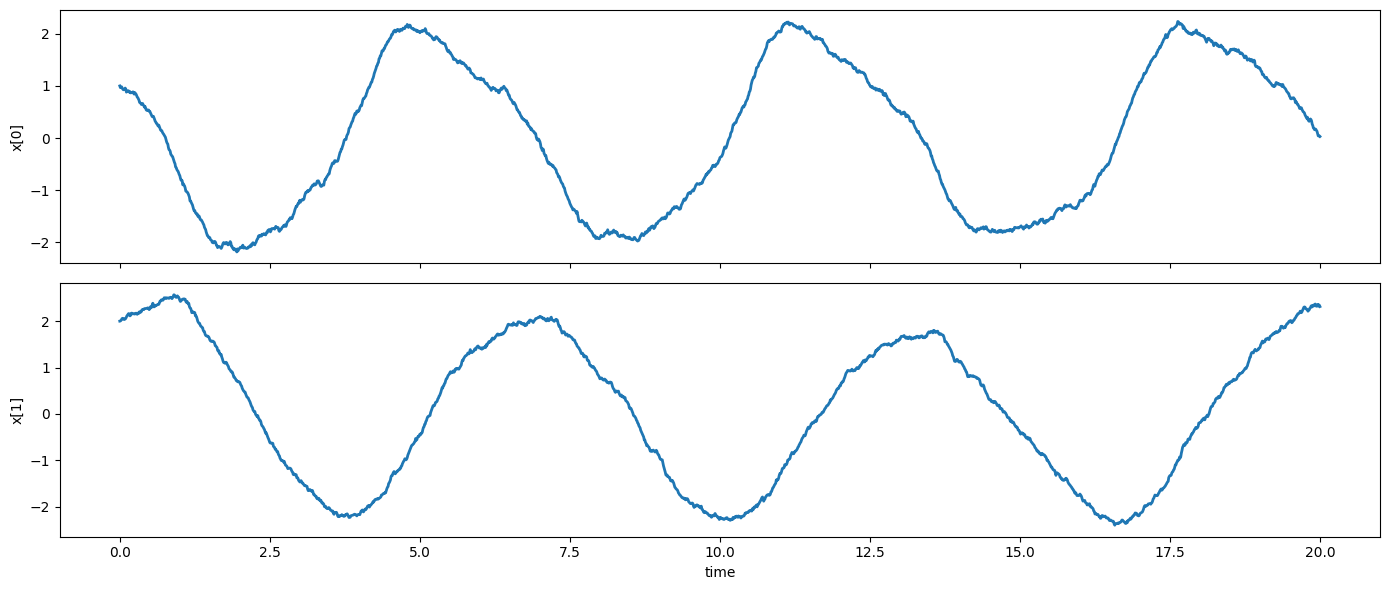

In [86]:
import numpy as np, matplotlib.pyplot as plt
from neuromancer import psl

# 1) pick system + simulate one trajectory
dt, T, sigma = 0.01, 2000, 0.20
sys = psl.systems['VanDerPol']()   # or your favorite psl system
X = em_rollout_system(sys, T=T, dt=dt, sigma=sigma, seed=123)   # [T+1, nx]
t = np.arange(T+1)*dt
nx = X.shape[1]

# 2) plot states
fig, axes = plt.subplots(nx, 1, figsize=(14, 3*nx), sharex=True)
if nx == 1: axes = [axes]
for i in range(nx):
    axes[i].plot(t, X[:, i], lw=2)
    axes[i].set_ylabel(f"x[{i}]")
axes[-1].set_xlabel("time")
plt.tight_layout(); plt.show()


## Neuromancer Codes

Please see `create_modular_ut_system`. Data flow is 
```
mu, var, u → sigma_points, W → sigma_points_next → mu_next, var_next
```




In [ ]:


import torch
import torch.nn as nn
import numpy as np
from typing import Dict, List, Optional, Tuple
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass

import neuromancer as nm
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics.integrators import DiffEqIntegrator

# ==============================================================================
# UTILITY FUNCTIONS
# ==============================================================================

def cholesky_psd(A: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    I = torch.eye(A.shape[-1], device=A.device, dtype=A.dtype)
    return torch.linalg.cholesky(A + eps * I)

def ut_weights_torch(n: int, alpha=1e-3, beta=2.0, kappa=0.0,
                     device="cpu", dtype=torch.float32) -> Tuple[float, torch.Tensor, torch.Tensor]:
    lam = alpha**2 * (n + kappa) - n
    Wm = torch.zeros(2*n+1, device=device, dtype=dtype)
    Wc = torch.zeros(2*n+1, device=device, dtype=dtype)
    Wm[0] = lam/(n+lam)
    Wc[0] = lam/(n+lam) + (1 - alpha**2 + beta)
    Wm[1:] = Wc[1:] = 1.0/(2*(n+lam))
    return lam, Wm, Wc

# ==============================================================================
# UTINTEGRATOR (YOUR CODE)
# ==============================================================================


"""
class UTIntegrator(DiffEqIntegrator):
    def __init__(self,
                 block_rhs: nn.Module,
                 dt: float = 0.01,
                 method: str = 'dopri5',
                 rtol: float = 1e-5,
                 atol: float = 1e-7,
                 sigma_val: float = 0.1,
                 include_diffusion: bool = True,
                 nx: int = 1,
                 nu: int = 1,
                 g2_net: nn.Module | None = None,
                 interp_u=None):
        
 
        super().__init__(block=block_rhs, interp_u=interp_u, h=dt, method=method)
        
        self.sigma_val = sigma_val
        self.include_diffusion = include_diffusion
        self.nx = nx
        self.nu = nu
        self.g2_net = g2_net
        
    def integrate(self, sigma_points: torch.Tensor, *args) -> torch.Tensor:
        """Integrate sigma points through dynamics."""
        B, S, D = sigma_points.shape
        device, dtype = sigma_points.device, sigma_points.dtype
        
        ptr = 0
        x = sigma_points[..., ptr:ptr + self.nx]  # [B, S, nx]
        ptr += self.nx
        u = sigma_points[..., ptr:ptr + self.nu] if self.nu > 0 else None  # [B, S, nu] or None
        ptr += self.nu
        w = sigma_points[..., ptr:ptr + self.nx] if self.include_diffusion else None  # [B, S, nx] or None
        
        # Flatten for batch integration
        x_flat = x.reshape(-1, self.nx)  # [B*S, nx]
        u_flat = u.reshape(-1, self.nu) if u is not None else None  # [B*S, nu] or None
        
        # Use base integrate method
        x_next_flat = super().integrate(x_flat, u_flat) if u_flat is not None else super().integrate(x_flat)
        x_next = x_next_flat.view(B, S, self.nx)  # [B, S, nx]
        
        if self.include_diffusion:
            if self.g2_net: 
                g2_sigma = self.g2_net(x,u).clamp_min(0.0)
                sqrt_term = torch.sqrt(2.0* g2_sigma * self.h)
            else: 
                sigma_val = torch.as_tensor(self.sigma_val, device=device, dtype=dtype)
                if sigma_val.ndim == 0:
                    sigma_val = sigma_val.repeat(self.nx)
                g2 = 0.5 * (sigma_val ** 2)  # [nx]
                sqrt_term = torch.sqrt(2.0 * g2 * self.h)  # [nx]
            diffusion_term = sqrt_term[None, None, :] * w  # [B, S, nx]
            x_next = x_next + diffusion_term
        
        return x_next  # [B, S, nx]
    
"""
import torch
import torch.nn as nn
from neuromancer.dynamics.integrators import DiffEqIntegrator

class UTIntegrator(DiffEqIntegrator):
    """
    Unscented-Transform integrator over sigma points.

    Expects sigma_points laid out as:
      [x, (u), (w)]
        x: [B,S,nx]
        u: [B,S,nu] if nu>0 else omitted
        w: [B,S,nw_eff] (when include_diffusion=True). By default we assume nw_eff == nx.

    Drift (g1) comes from `block_rhs` (your MLP). Diffusion (g2) can be:
      - learned via `g2_net(x,(u))` -> [B,S,nx], or
      - a constant sigma value (`sigma_val`) used as fallback.
    """

    def __init__(self,
                 block_rhs: nn.Module,
                 dt: float = 0.01,
                 method: str = 'rk4',
                 include_diffusion: bool = True,
                 nx: int = 1,
                 nu: int = 0,
                 g2_net: nn.Module | None = None,
                 sigma_val: float | torch.Tensor = 0.0,
                 use_base_solver: bool = False,
                 interp_u=None):
        # DiffEqIntegrator uses h=dt internally
        super().__init__(block=block_rhs, interp_u=interp_u, h=dt, method=method)
        self.include_diffusion = include_diffusion
        self.nx, self.nu = nx, nu
        self.g2_net = g2_net
        self.sigma_val = sigma_val
        self.use_base_solver = use_base_solver  # if True, call super().integrate for drift


    def integrate(self, sigma_points: torch.Tensor, *args) -> torch.Tensor:
        """
        sigma_points: [B, S, D] where D = nx + (nu if present) + (nw_eff if include_diffusion)
        Returns:
          x_next: [B, S, nx]
        """
        B, S, D = sigma_points.shape
        device, dtype = sigma_points.device, sigma_points.dtype

        # --- parse [x, (u), (w)] ---
        ptr = 0
        x = sigma_points[..., ptr:ptr + self.nx]; ptr += self.nx          # [B,S,nx]
        u = None
        if self.nu > 0:
            u = sigma_points[..., ptr:ptr + self.nu]; ptr += self.nu      # [B,S,nu]
        w = None
        if self.include_diffusion:
            w = sigma_points[..., ptr:ptr + self.nx]                      # assume nw_eff == nx

        # --- DRIFT step (g1) ---
        if u is not None:
            x_u = torch.cat([x, u], dim=-1)                                # [B,S,nx+nu]
        else:
            x_u = x                                                        # [B,S,nx]

        if self.use_base_solver:
            # Use parent integrator (flattens batch of sigma points)
            x_flat = x.reshape(-1, self.nx)                                # [B*S,nx]
            u_flat = u.reshape(-1, self.nu) if u is not None else None     # [B*S,nu] or None
            x_next_flat = super().integrate(x_flat, u_flat)                # [B*S,nx]
            x_next = x_next_flat.view(B, S, self.nx)                       # [B,S,nx]
        else:
            # One-step Euler with your block (consistent with your training)
            drift = self.block(x_u.reshape(-1, x_u.shape[-1]))             # [B*S,nx]
            drift = drift.view(B, S, self.nx)
            x_next = x + self.h * drift                                    # [B,S,nx]

        # --- DIFFUSION step (g2) ---
        if self.include_diffusion:
            if w is None:
                raise RuntimeError("include_diffusion=True but noise sigma points `w` are missing.")

            # learned g2 per sigma point OR constant fallback
            if self.g2_net is not None:
                g2_in = x_u.reshape(-1, x_u.shape[-1])                     # [B*S, nx(+nu)]
                g2_sigma = self.g2_net(g2_in).view(B, S, self.nx)          # [B,S,nx]
                g2_sigma = g2_sigma.clamp_min(0.0)                         # ensure >=0
                sqrt_term = torch.sqrt((2.0 * g2_sigma * self.h).clamp_min(1e-12))  # [B,S,nx]
            else:
                # sigma_val can be scalar, [nx], [B,S,nx]; broadcast to [B,S,nx]
                sv = torch.as_tensor(self.sigma_val, device=device, dtype=dtype)
                if sv.ndim == 0:
                    sv = sv.view(1, 1, 1).expand(B, S, self.nx)
                elif sv.ndim == 1 and sv.shape[0] == self.nx:
                    sv = sv.view(1, 1, self.nx).expand(B, S, self.nx)
                elif sv.shape != (B, S, self.nx):
                    raise ValueError(f"sigma_val shape {tuple(sv.shape)} not broadcastable to [B,S,nx].")
                g2_const = 0.5 * (sv ** 2)                                  # [B,S,nx]
                sqrt_term = torch.sqrt((2.0 * g2_const * self.h).clamp_min(1e-12))

            # EM increment: x_{k+1} = x_next + sqrt(2 g2 h) * w
            x_next = x_next + sqrt_term * w                                 # [B,S,nx]

        return x_next


# ==============================================================================
# SIGMA POINT NODES
# ==============================================================================

class SigmaPointGenerator(nn.Module):
    def __init__(self, include_diffusion: bool = True,
                 alpha: float = 1e-3, beta: float = 2.0, kappa: float = 0.0,
                 nw: int = 0):
        super().__init__()
        self.include_diffusion = include_diffusion
        self.alpha, self.beta, self.kappa = alpha, beta, kappa
        # number of augmented noise dims; if include_diffusion and nw==0, we’ll set nw=nx at runtime
        self.nw = nw

    @torch.no_grad()
    def forward(self, mu: torch.Tensor, var: torch.Tensor, u: torch.Tensor | None = None):
  
        """
        mu:  [B, nx]
        var: [B, nx]  (diag variances; >=0)
        u:   [B, nu] or [nu] or [1, nu] or None

        returns:
        sigma_points: [B, S, nx + (nu if u provided) + (nw_eff if include_diffusion)]
        Wm:           [B, S]
        """
        device, dtype = mu.device, mu.dtype
        

        if mu.ndim == 3 and mu.shape[1] == 1:
            mu = mu.squeeze(1)   # [B, nx]
        if var.ndim == 3 and var.shape[1] == 1:
            var = var.squeeze(1) # [B, nx]
        if u is not None and u.ndim == 3 and u.shape[1] == 1:
            u = u.squeeze(1)     # [B, nu]
        
        B ,nx = mu.shape

        # ---------- normalize u ----------
        if u is None:
            nu = 0
            u_norm = None
        else:
            if u.ndim == 1:                  # [nu]
                u = u.unsqueeze(0)           # [1, nu]
            if u.shape[0] == 1 and B > 1:    # [1, nu] -> broadcast to [B, nu]
                u = u.expand(B, -1)
            if u.shape[0] != B:
                raise ValueError(f"u batch {u.shape[0]} != mu batch {B}")
            u_norm = u.to(device=device, dtype=dtype)
            nu = u_norm.shape[-1]

        # ---------- choose noise augmentation ----------
        nw_eff = 0
        if self.include_diffusion:
            # common: 1D->1 noise, multi-D->nx noise; or user-specified self.nw
            nw_eff = self.nw if getattr(self, "nw", 0) > 0 else (1 if nx == 1 else nx)

        n = nx + nw_eff                         # UT dim (states + noise), u is exogenous
        lam, Wm, _ = ut_weights_torch(n, self.alpha, self.beta, self.kappa, device, dtype)
        S = 2 * n + 1
        WmB = Wm.unsqueeze(0).expand(B, S)      # [B, S]

        # ---------- build sigma points for [x, w] ----------
        state_std = torch.sqrt(var.clamp_min(1e-12))                 # [B, nx]
        if nw_eff > 0:
            noise_std = torch.ones(B, nw_eff, device=device, dtype=dtype)
            std_all = torch.cat([state_std, noise_std], dim=-1)      # [B, n]
            center  = torch.cat([mu, torch.zeros(B, nw_eff, device=device, dtype=dtype)], dim=-1)  # [B, n]
        else:
            std_all = state_std                                      # [B, n=nx]
            center  = mu

        scale = torch.sqrt(torch.tensor(n + lam, device=device, dtype=dtype))  # scalar
        eye   = torch.eye(n, device=device, dtype=dtype)[None].expand(B, -1, -1)  # [B, n, n]
        # columns of scaled = scaled basis vectors times per-dim std
        scaled = scale * std_all.unsqueeze(-1) * eye                 # [B, n, n]

        deltas = torch.zeros(B, S, n, device=device, dtype=dtype)
        deltas[:, 1:1+n, :]     =  scaled.transpose(1, 2)            # +columns
        deltas[:, 1+n:1+2*n, :] = -scaled.transpose(1, 2)            # -columns
        chi = center.unsqueeze(1) + deltas                           # [B, S, n] (augmented [x,w])

        # split back
        x_sigma = chi[..., :nx]                                       # [B, S, nx]
        if nw_eff > 0:
            w_sigma = chi[..., nx:]                                   # [B, S, nw_eff]

        # ---------- append exogenous u (if any) ----------
        if nu > 0:
            u_rep = u_norm.unsqueeze(1).expand(B, S, nu)              # [B, S, nu]
            if nw_eff > 0:
                sigma_points = torch.cat([x_sigma, u_rep, w_sigma], dim=-1)  # [B, S, nx+nu+nw_eff]
            else:
                sigma_points = torch.cat([x_sigma, u_rep], dim=-1)          # [B, S, nx+nu]
        else:
            sigma_points = torch.cat([x_sigma, w_sigma], dim=-1) if nw_eff > 0 else x_sigma  # [B, S, nx(+nw)]

        return sigma_points, WmB


        



class InverseSigmaPointNode(nn.Module):
    """Compute mean and variance from weighted sigma points."""
    
    def __init__(self, compute_variance: bool = False):
       
        super().__init__()
        self.compute_variance = compute_variance
        
    def forward(self, sigma_points_next, W):
          
        
        # Compute weighted mean
        W_expanded = W.unsqueeze(-1)  # [B, S, 1]
        mu_next = (W_expanded * sigma_points_next).sum(dim=1)  # [B, nx]
        
        result = mu_next
        
        # Dummy
        var_next = None
        if self.compute_variance:
            # Compute weighted variance
            diff = sigma_points_next - mu_next.unsqueeze(1)  # [B, S, nx]
            var_next = (W_expanded * diff**2).sum(dim=1)     # [B, nx]
           
            
        return result, var_next #Var here is dummy

# ==============================================================================
# SYSTEM CREATION
# ==============================================================================

def create_modular_ut_system(
    dynamics_net,
    nx: int = 1,
    nu: int = 1,
    dt: float = 0.01,
    sigma_val: float = 0.1,
    include_diffusion: bool = True,
    compute_variance: bool = False,
    method: str = 'rk4',
    rtol: float = 1e-5,
    atol: float = 1e-7
) -> System:
    """
    Create complete modular UT system.
    
    Args:
        dynamics_net: Neural network f(x, u) -> dx
        nx: State dimension
        nu: Control dimension  
        dt: Integration time step
        sigma_val: Diffusion strength
        include_diffusion: Whether to include stochastic diffusion
        compute_variance: Whether to compute output variance
        method: ODE integration method
        rtol: Relative tolerance
        atol: Absolute tolerance
        
    Returns:
        Complete System: mu, var, u -> mu_next, [var_next]
    """

    rhs_fx = dynamics_net
    
    # Node 1: Generate sigma points
    sigma_gen_func = SigmaPointGenerator(
        include_diffusion=include_diffusion,
       
    )

    sigma_gen_node = Node( sigma_gen_func, 
                            input_keys=['mu0', 'var0'],
                            output_keys=['sigma_points', 'W']
                        )
    
    # Node 2: Apply dynamics with UTIntegrator
    ut_integrator = UTIntegrator(
        block_rhs=dynamics_net,
        dt=dt,
        method=method,
        sigma_val=sigma_val,
        include_diffusion=include_diffusion,
        nx=nx,
        nu=nu
    )

    integrator_node = Node(ut_integrator, input_keys=['sigma_points', 'W'], output_keys=['sigma_points_next'])
    

    
    # Node 3: Reconstruct moments
    inverse_sigma = InverseSigmaPointNode(
        compute_variance=True #dummy
    )

    inverse_sigma_node = Node(inverse_sigma, 
                        input_keys=['sigma_points_next', 'W'],
                        output_keys=['mu0', 'var0'])
    
    # Assemble system
    nodes = [sigma_gen_node, integrator_node, inverse_sigma_node]
    system = System(nodes, name='modular_ut_system', nsteps=2)
    
    return nodes, system

# ==============================================================================
# CONFIGURATION
# ==============================================================================

@dataclass
class UTSystemConfig:
    """Configuration for UT system."""
    # System parameters
    nx: int = 1              # State dimension
    nu: int = 1              # Control dimension
    dt: float = 0.01         # Time step
    sigma_val: float = 0.1   # Diffusion strength
    include_diffusion: bool = True
    compute_variance: bool = False
    
    # Integration parameters
    method: str = 'dopri5'   # ODE method
    rtol: float = 1e-5       # Relative tolerance
    atol: float = 1e-7       # Absolute tolerance
    
    # Network parameters
    hidden_dim: int = 64     # Hidden layer size
    n_layers: int = 2        # Number of hidden layers
    
    # Training parameters
    batch_size: int = 128
    epochs: int = 20
    lr: float = 1e-3
    train_frac: float = 0.7
    val_frac: float = 0.15
    device: str = "cpu"


In [18]:
foo['X'].shape

torch.Size([200, 2, 64])

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# define neural network of the NODE
fx = blocks.MLP(2, 2, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[60, 60, 60])


nodes,system = create_modular_ut_system(dynamics_net=fx, nx=2, nu=0)


In [76]:
foo = next(iter(train_loader))

In [65]:
# %% Constraints + losses:
x = variable("mu")
xhat = variable('mu0')[:, :-1, :]
# finite difference variables
xFD = (x[:, 1:, :] - x[:, :-1, :])
xhatFD = (xhat[:, 1:, :] - xhat[:, :-1, :])

# trajectory tracking loss
reference_loss = (xhat == x)^2
reference_loss.name = "ref_loss"

# finite difference loss
fd_loss = 2.*(xFD == xhatFD)^2
fd_loss.name = 'FD_loss'

# aggregate list of objective terms and constraints
objectives = [reference_loss, fd_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([system], loss)


from neuromancer.loggers import BasicLogger

optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=[ 'train_loss'])
# define neuromancer trainer
trainer = Trainer(
    problem,
    train_loader,
    train_loader,
    train_loader,
    optimizer,
    patience=50,
    warmup=0,
    epochs=20,
    eval_metric="train_loss",
    train_metric="train_loss",
    dev_metric="train_loss",
    test_metric="train_loss",
    logger=logger,
)

None
Number of parameters: 7622


In [145]:
system

System(
  (nodes): ModuleList(
    (0): node_1(mu0, var0) -> sigma_points, W
    (1): node_2(sigma_points, W) -> sigma_points_next
    (2): node_3(sigma_points_next, W) -> mu0, var0
  )
)

In [66]:
trainer.train()

epoch: 0	train_loss: 0.00847	eltime:  3.41639
epoch: 1	train_loss: 0.00705	eltime:  3.97343
epoch: 2	train_loss: 0.01140	eltime:  4.49688
epoch: 3	train_loss: 0.01281	eltime:  5.02287
epoch: 4	train_loss: 0.01009	eltime:  5.56973
epoch: 5	train_loss: 0.01010	eltime:  6.11153
epoch: 6	train_loss: 0.01501	eltime:  6.64552
epoch: 7	train_loss: 0.00963	eltime:  7.16952
epoch: 8	train_loss: 0.01292	eltime:  7.69220
epoch: 9	train_loss: 0.02843	eltime:  8.25542
epoch: 10	train_loss: 0.00727	eltime:  8.82633
epoch: 11	train_loss: 0.01166	eltime:  9.36412
epoch: 12	train_loss: 0.01686	eltime:  9.90180
epoch: 13	train_loss: 0.00969	eltime:  10.43650
epoch: 14	train_loss: 0.01389	eltime:  10.96664
epoch: 15	train_loss: 0.00961	eltime:  11.47911
epoch: 16	train_loss: 0.00959	eltime:  12.04534
epoch: 17	train_loss: 0.01172	eltime:  12.56872
epoch: 18	train_loss: 0.01336	eltime:  13.08742
epoch: 19	train_loss: 0.01133	eltime:  13.61499


OrderedDict([('nodes.0.nodes.1.callable.block.linear.0.weight',
              tensor([[-0.0978, -0.1413],
                      [ 0.5944,  0.0995],
                      [-0.3910, -0.0571],
                      [ 0.4000,  0.6894],
                      [ 0.2134, -0.0416],
                      [ 0.5568, -0.2981],
                      [ 0.3793,  0.6999],
                      [-0.3582,  0.1101],
                      [-0.6583, -0.0938],
                      [ 0.0278,  0.0261],
                      [-0.4387,  0.3799],
                      [ 0.0990,  0.1129],
                      [-0.4454, -0.2249],
                      [-0.4211,  0.5056],
                      [-0.2092,  0.2059],
                      [-0.3766,  0.6662],
                      [-0.2040,  0.1900],
                      [ 0.1099,  0.1252],
                      [ 0.3740, -0.1841],
                      [-0.2585,  0.6729],
                      [-0.0502,  0.0624],
                      [-0.2490,  0.0332],
            

## Evaluate on longer rollout

torch.Size([100, 20, 2])


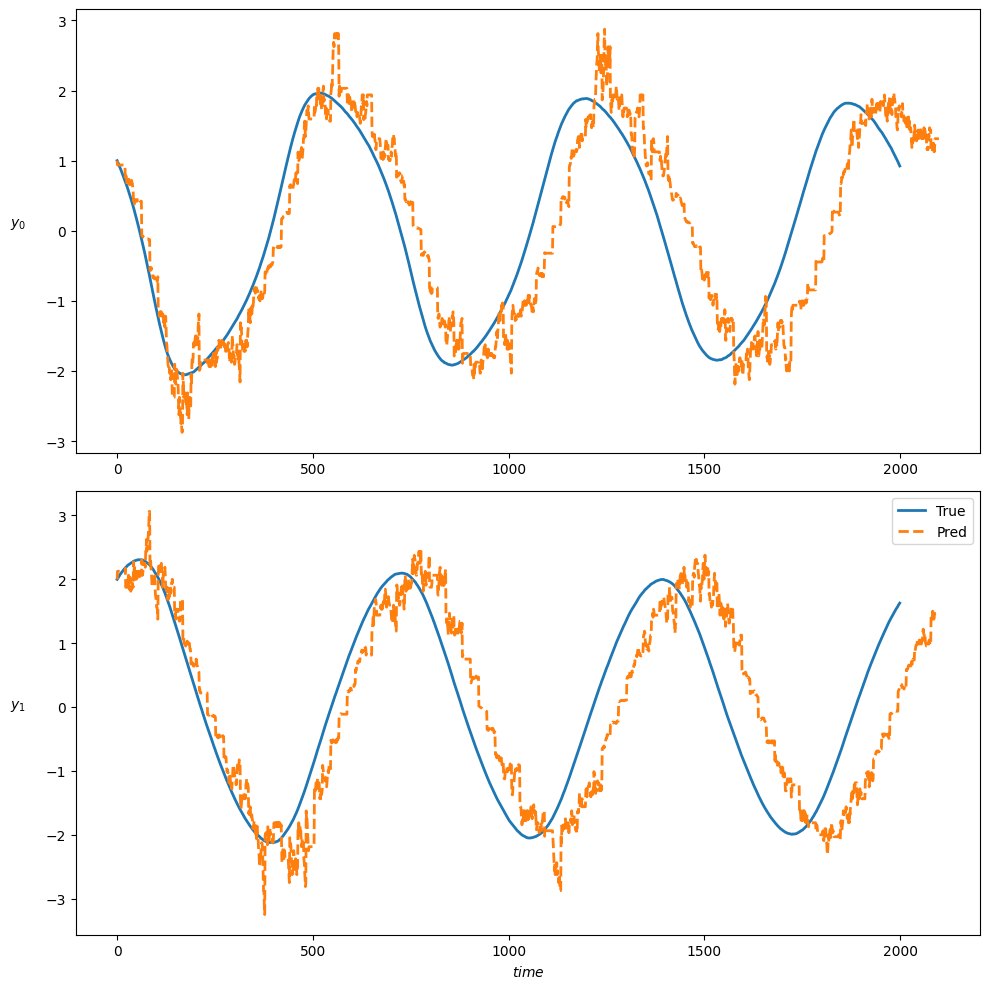

In [ ]:
# ---------- 1) Make an in-distribution TEST split ----------

from neuromancer import psl
psl_class = psl.systems['VanDerPol']


test_data_raw = get_mc_data(
    system_class=psl_class,
    nsteps_total=2000,
    nsteps_per_batch=20,
    dt=0.01,
    batch_size=16,      
    experiments=256,
    sigma=.2,
    seed=999,           # <= different seed from training
)[0]  

# Wrap with stats so we have mu/var keys
test_wrapped = WithStats4D(test_data_raw, exp_dim=-1, unbiased=False)


test_loader = DataLoader(
    test_wrapped,
    batch_size=len(test_wrapped),
    shuffle=False,
    collate_fn=test_wrapped.collate_fn
)

test_batch = next(iter(test_loader))    
for k,v in test_batch.items():            
    if isinstance(v, torch.Tensor):
        test_batch[k] = v.to(device)

T = test_batch['X'].shape[1]            
system.nsteps = T


with torch.no_grad():
    test_outputs = system(test_batch)     
    print(test_outputs['mu'].shape)

pred_traj = test_outputs['mu0']           # [B, T, nx]
true_traj = test_batch['mu']              # [B, T, nx]



import matplotlib.pyplot as plt

B, T, nx = pred_traj.shape
pred_np = pred_traj.detach().cpu().numpy().reshape(-1, nx).T  # [nx, B*T]
true_np = true_traj.detach().cpu().numpy().reshape(-1, nx).T  # [nx, B*T]

figsize = 10
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(nx)]
for row in range(nx):
    axe = ax[row] if nx > 1 else ax
    axe.set_ylabel(labels[row], rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(true_np[row], linewidth=2.0, label='True')
    axe.plot(pred_np[row], '--', linewidth=2.0, label='Pred')
    axe.tick_params(labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()
plt.show()


### Updated UTIntegrator 
Takes in deterministic Neuromancer integrator+block

In [ ]:
import torch
import torch.nn as nn
import warnings

class UTIntegrator(nn.Module):
    """
    UT wrapper that uses a provided deterministic Neuromancer integrator for the drift step
    """

    def __init__(self,
                 drift_integrator: nn.Module,          # e.g. RK4(block=mlp, h=dt) or DiffEqIntegrator(...)
                 include_diffusion: bool = True,
                 nx: int = 1,
                 nu: int = 0,
                 g2_net: nn.Module | None = None,
                 sigma_val: float | torch.Tensor = 0.0):
        super().__init__()
        self.drift_integrator = drift_integrator
        self.include_diffusion = include_diffusion
        self.nx, self.nu = nx, nu
        self.g2_net = g2_net
        self.sigma_val = sigma_val

        if not hasattr(drift_integrator, "block"):
            raise ValueError("drift_integrator must have a `.block` attribute (Neuromancer-style).")
        self.block = drift_integrator.block

        self.h = getattr(drift_integrator, "h", 1.0)
        if not hasattr(drift_integrator, "h"):
            warnings.warn("drift_integrator has no attribute `.h`; defaulting UT step to h=1.0.", RuntimeWarning)

    def forward(self, sigma_points: torch.Tensor, *args) -> torch.Tensor:
        """
        sigma_points: [B, S, D] where D = nx + (nu if present) + (nx if include_diffusion)
        returns x_next: [B, S, nx]
        """
        B, S, _ = sigma_points.shape
        device, dtype = sigma_points.device, sigma_points.dtype

        # --- parse [x, (u), (w)] ---
        ptr = 0
        x = sigma_points[..., ptr:ptr + self.nx]; ptr += self.nx          # [B,S,nx]
        u = None
        if self.nu > 0:
            u = sigma_points[..., ptr:ptr + self.nu]; ptr += self.nu      # [B,S,nu]
        w = None
        if self.include_diffusion:
            w = sigma_points[..., ptr:ptr + self.nx]                      # [B,S,nx]

        # --- DRIFT step via wrapped integrator (single step) ---
        x_flat = x.reshape(-1, self.nx)                                   # [B*S,nx]
        if u is not None:
            u_flat = u.reshape(-1, self.nu)                               # [B*S,nu]
            x_next_flat = self.drift_integrator.integrate(x_flat, u_flat)
        else:
            x_next_flat = self.drift_integrator.integrate(x_flat)
        x_next = x_next_flat.view(B, S, self.nx)                          # [B,S,nx]

        # --- DIFFUSION step (EM increment) ---
        if self.include_diffusion:
            if w is None:
                raise RuntimeError("include_diffusion=True but noise sigma points `w` are missing.")

            # Build input to g2 if needed: x_u
            x_u = torch.cat([x, u], dim=-1) if (u is not None) else x     # [B,S,nx(+nu)]

            if self.g2_net is not None:
                g2_in = x_u.reshape(-1, x_u.shape[-1])                    # [B*S, nx(+nu)]
                g2_sigma = self.g2_net(g2_in).view(B, S, self.nx)         # [B,S,nx]
                g2_sigma = g2_sigma.clamp_min(0.0)
                sqrt_term = torch.sqrt((2.0 * g2_sigma * self.h).clamp_min(1e-12))
            else:
                sv = torch.as_tensor(self.sigma_val, device=device, dtype=dtype)
                if sv.ndim == 0:
                    sv = sv.view(1, 1, 1).expand(B, S, self.nx)
                elif sv.ndim == 1 and sv.shape[0] == self.nx:
                    sv = sv.view(1, 1, self.nx).expand(B, S, self.nx)
                elif sv.shape != (B, S, self.nx):
                    raise ValueError(f"sigma_val shape {tuple(sv.shape)} not broadcastable to [B,S,nx].")
                # interpret sigma_val as std: g2 = 0.5 * sigma^2
                g2_const = 0.5 * (sv ** 2)
                sqrt_term = torch.sqrt((2.0 * g2_const * self.h).clamp_min(1e-12))

            x_next = x_next + sqrt_term * w                               # [B,S,nx]

        return x_next
    



#### Updated System Creation

In [ ]:
from neuromancer.dynamics.integrators import DiffEqIntegrator

def create_modular_ut_system(
    dynamics_net,
    nx: int = 1,
    nu: int = 1,
    dt: float = 0.01,
    sigma_val: float = 0.1,
    include_diffusion: bool = True,
    compute_variance: bool = False,
    method: str = 'rk4'
) -> System:
    """
    Create complete modular UT system.

    Args:
        dynamics_net: Neural network f(x, u) -> dx
        nx: State dimension
        nu: Control dimension
        dt: Integration time step
        sigma_val: Diffusion strength (std); if tensor, broadcastable to [B,S,nx]
        include_diffusion: Whether to include stochastic diffusion
        compute_variance: Whether to compute output variance in the inverse node
        method: ODE integration method for deterministic drift step (e.g., 'rk4', 'euler', 'dopri5')

    Returns:
        nodes, system
    """

    # --- Node 1: Generate sigma points (with augmented control u) ---
    sigma_gen_node = Node(
        SigmaPointGenerator(include_diffusion=include_diffusion),
        input_keys=['mu0', 'var0', 'u0'],             
        output_keys=['sigma_points', 'W']
    )

    # --- Deterministic Neuromancer integrator
    drift_step = DiffEqIntegrator(block=dynamics_net, h=dt, method=method)


    ut_integrator = UTIntegrator(
        drift_integrator=drift_step,                  # <-- key change: pass the built integrator
        include_diffusion=include_diffusion,
        nx=nx,
        nu=nu,                                       
        g2_net=None,      #note None for training g1; once g2 is trained it gets plugged in here                            
        sigma_val=sigma_val
    )
    integrator_node = Node(
        ut_integrator,
        input_keys=['sigma_points', 'W'],
        output_keys=['sigma_points_next']
    )


    inverse_sigma_node = Node(
        InverseSigmaPointNode(compute_variance=compute_variance),
        input_keys=['sigma_points_next', 'W'],
        output_keys=['mu0', 'var0']           
    )


    nodes = [sigma_gen_node, integrator_node, inverse_sigma_node]
    system = System(nodes, name='modular_ut_system', nsteps=2)

    return nodes, system


## Training G2 (Pytorch)

In [35]:
@torch.no_grad()
def make_g2_targets_with_integrator(
    batch: dict,
    sigma_gen,              # SigmaPointGenerator (your class)
    ut_no_diff,             # UTIntegrator(include_diffusion=False, g2_net=None)
    dt: float,
    nx: int,
    nu: int = 0,
):
    """
    Returns:
      X_g2: [N, nx(+nu)]   inputs at time k (we use mu_k and optional u_k)
      Y_g2: [N, nx]        targets g2(x_k,u_k)
    Assumes nw_eff == nx (one noise axis per state).
    """
    device = batch['mu'].device
    dtype  = batch['mu'].dtype

    mu   = batch['mu']            # [B,T,nx]
    var  = batch['var']           # [B,T,nx]
    mu_p = mu[:, 1:, :]           # [B,T-1,nx]
    var_p= var[:, 1:, :]          # [B,T-1,nx]
    mu   = mu[:, :-1, :]          # [B,T-1,nx]
    var  = var[:, :-1, :]

    B, Tm1, _ = mu.shape
    N = B*Tm1

    mu_flat  = mu.reshape(-1, nx)         # [N,nx]
    var_flat = var.reshape(-1, nx)        # [N,nx]
    mu_p_flat  = mu_p.reshape(-1, nx)     # [N,nx]
    var_p_flat = var_p.reshape(-1, nx)    # [N,nx]

    # If you have u per-time, wire it here as [B,T,nu] → u_flat = [N,nu]
    u_flat = None

    # --- Sigma points & UT weights ---
    sigma_points, WmB = sigma_gen(mu_flat, var_flat, u_flat)     # [N,S,D], [N,S]
    N_, S, D = sigma_points.shape
    assert N_ == N
    # unpack (x,(u),w)
    if nu > 0:
        x_sigma = sigma_points[..., :nx]
        u_sigma = sigma_points[..., nx:nx+nu]
        w_sigma = sigma_points[..., nx+nu:]       # [N,S,nw_eff]
        x_u_sigma = torch.cat([x_sigma, u_sigma], dim=-1)
    else:
        x_sigma = sigma_points[..., :nx]
        w_sigma = sigma_points[..., nx:]          # [N,S,nw_eff]
        x_u_sigma = x_sigma

    nw_eff = 0 if w_sigma is None else w_sigma.shape[-1]
    if nw_eff != nx:
        raise RuntimeError("Assuming nw_eff == nx (one noise axis per state).")

    # --- Drift-only propagation via your integrator ---
    # Build the same packed tensor the integrator expects: [x, (u), w]
    # Even with include_diffusion=False, we can pass the full tensor.
    y_det = ut_no_diff.integrate(sigma_points)    # [N,S,nx] one data step ahead

    # --- UT weights for covariance ---
    n_aug = nx + nw_eff                           # UT dimension (x + w)
    _, Wm_1d, Wc_1d = ut_weights_torch(n_aug, sigma_gen.alpha, sigma_gen.beta, sigma_gen.kappa,
                                       device=device, dtype=dtype)
    Wc = Wc_1d.view(1, S, 1)                      # [1,S,1]

    # var_pt_1 = sum_s Wc[s] * (y_det - mu_{k+1})^2
    y_minus_mean = y_det - mu_p_flat.unsqueeze(1)       # [N,S,nx]
    var_pt_1 = torch.sum(Wc * (y_minus_mean**2), dim=1) # [N,nx]

    # var_pt_2 term (same algebra as the TF code)
    # Use deterministic step at the mean (center sigma)
    # (center = mu_k → push one step with drift only)
    det_mean = mu_flat + (y_det[:, 0, :] - x_sigma[:, 0, :])     # also equal to: mu_k + g1(mu_k)*dt
    w_diag_weight = Wc_1d[nx+1]                                  # scalar
    var_pt_2 = w_diag_weight * ( 2*(det_mean**2) + 2*(mu_p_flat**2) - 4*(det_mean*mu_p_flat) )

    # chi_w^2 per state: read +w_i axis column; by construction it's S-index 1 + (nx + i)
    chi_w_sq = []
    for i in range(nx):
        s_plus = 1 + (nx + i)            # +axis for w_i
        chi_w_i = w_sigma[:, s_plus, i]  # [N]
        chi_w_sq.append(chi_w_i**2)
    chi_w_sq = torch.stack(chi_w_sq, dim=-1)   # [N,nx]

    # g2 targets (>=0)
    numer = torch.clamp(var_p_flat - var_pt_1 - var_pt_2, min=0.0)      # [N,nx]
    denom = torch.clamp(4.0 * w_diag_weight * chi_w_sq * dt, min=1e-12)  # [N,nx]
    g2_target = numer / denom                                           # [N,nx]

    # Inputs X_g2: use mu_k (and u_k if available)
    X_g2 = mu_flat if u_flat is None else torch.cat([mu_flat, u_flat], dim=-1)
    Y_g2 = g2_target
    return X_g2, Y_g2


In [36]:
def build_g2_dataset(train_loader, fx, sigma_gen, dt, nx, nu, device):
    fx.eval()
    # integrator in deterministic mode (no diffusion)
    ut_no_diff = UTIntegrator(block_rhs=fx, dt=dt, method='rk4',
                              include_diffusion=False, nx=nx, nu=nu, g2_net=None).to(device)
    Xs, Ys = [], []
    for batch in train_loader:
        for k,v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
        X_g2, Y_g2 = make_g2_targets_with_integrator(batch, sigma_gen, ut_no_diff, dt, nx, nu)
        Xs.append(X_g2); Ys.append(Y_g2)
    return torch.cat(Xs,0), torch.cat(Ys,0)

In [37]:
# sigma_gen for target building; nw=0 → your class uses nx internally (one noise per state)
sigma_gen = SigmaPointGenerator(include_diffusion=True, nw=0).to(device)

Xg2, Yg2 = build_g2_dataset(
    train_loader=train_loader,
    fx=fx,                   # your trained g1 MLP
    sigma_gen=sigma_gen,
    dt=0.01,
    nx=2,
    nu=0,
    device=device,
)


In [38]:
class G2Net(nn.Module):
    def __init__(self, in_dim, out_dim, hs=(64,64)):
        super().__init__()
        layers, last = [], in_dim
        for h in hs:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(last, out_dim)
        self.softplus = nn.Softplus()   # g2 >= 0
    def forward(self, x):
        return self.softplus(self.head(self.backbone(x)))


def train_g2(g2, X, Y, epochs=50, lr=1e-3, bs=4096):
    ds = torch.utils.data.TensorDataset(X, Y)
    dl = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=True)
    opt = torch.optim.Adam(g2.parameters(), lr=lr)
    mse = nn.MSELoss()
    for ep in range(epochs):
        g2.train()
        running = 0.0
        for xb, yb in dl:
            opt.zero_grad()
            pred = g2(xb)
            loss = mse(pred, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
        if (ep+1) % 10 == 0:
            print(f"[g2] epoch {ep+1:03d}  loss {running/len(ds):.4e}")

    

In [39]:
g2 = G2Net(in_dim=Xg2.shape[-1], out_dim=Yg2.shape[-1]).to(device)
train_g2(g2, Xg2, Yg2, epochs=500, lr=1e-3, bs=128)

[g2] epoch 010  loss 4.2524e-01
[g2] epoch 020  loss 4.2336e-01
[g2] epoch 030  loss 4.2152e-01
[g2] epoch 040  loss 4.1865e-01
[g2] epoch 050  loss 4.1504e-01
[g2] epoch 060  loss 4.0881e-01
[g2] epoch 070  loss 4.0447e-01
[g2] epoch 080  loss 3.9971e-01
[g2] epoch 090  loss 3.9519e-01
[g2] epoch 100  loss 3.9352e-01
[g2] epoch 110  loss 3.8574e-01
[g2] epoch 120  loss 3.8332e-01
[g2] epoch 130  loss 3.8097e-01
[g2] epoch 140  loss 3.7867e-01
[g2] epoch 150  loss 3.7365e-01
[g2] epoch 160  loss 3.7187e-01
[g2] epoch 170  loss 3.6706e-01
[g2] epoch 180  loss 3.6726e-01
[g2] epoch 190  loss 3.6369e-01
[g2] epoch 200  loss 3.6311e-01
[g2] epoch 210  loss 3.6372e-01
[g2] epoch 220  loss 3.5654e-01
[g2] epoch 230  loss 3.5437e-01
[g2] epoch 240  loss 3.5171e-01
[g2] epoch 250  loss 3.5020e-01
[g2] epoch 260  loss 3.5197e-01
[g2] epoch 270  loss 3.4452e-01
[g2] epoch 280  loss 3.4203e-01
[g2] epoch 290  loss 3.4320e-01
[g2] epoch 300  loss 3.3788e-01
[g2] epoch 310  loss 3.3102e-01
[g2] epo

# Uncertainty Quantification

In [ ]:
# --- integrator that uses learned g2 ---
ut_integrator = UTIntegrator(
    block_rhs=fx,        #trained g1 MLP
    dt=0.01,
    method='rk4',
    include_diffusion=True,
    nx=2, nu=0,
    g2_net=g2           #trained G2
)

# --- nodes (same wiring as your training system) ---
sigma_gen_func = SigmaPointGenerator(include_diffusion=True, nw=0)  # nw=0 -> nx noise internally
sigma_gen_node = Node(
    sigma_gen_func,
    input_keys=['mu0', 'var0'],          # seed each window with initial mean/var
    output_keys=['sigma_points', 'W']
)

integrator_node = Node(
    ut_integrator,
    input_keys=['sigma_points', 'W'],
    output_keys=['sigma_points_next']
)

inverse_sigma = InverseSigmaPointNode(compute_variance=True)
inverse_sigma_node = Node(
    inverse_sigma,
    input_keys=['sigma_points_next', 'W'],
    output_keys=['mu0', 'var0']          # feed back to next step
)

system = System([sigma_gen_node, integrator_node, inverse_sigma_node],
                name='modular_ut_system')

# wrap your dev_data in WithStats4D so it has mu/var/mu0/var0
wrapped_dev = WithStats4D(dev_data, exp_dim=-1, unbiased=False)
dev_loader = DataLoader(wrapped_dev, batch_size=16, shuffle=False,
                        collate_fn=wrapped_dev.collate_fn)

import torch

batch = next(iter(dev_loader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)

# rollout length = window length in this batch
T = batch['X'].shape[1]          # [B,T,nx,E]
system.nsteps = T                # unroll T steps

# run system starting from (mu0, var0)
outputs = system({'mu0': batch['mu0'], 'var0': batch['var0']})
pred_mu  = outputs['mu0']        # [B, T, nx]
pred_var = outputs['var0']       # [B, T, nx]


true_mu  = batch['mu']           # [B,T,nx]
true_var = batch['var']          # [B,T,nx]
E = batch['X'].shape[-1]

# per-state (marginal) 95% bands from UT variance:
pred_std   = torch.sqrt(pred_var.clamp_min(1e-12))
band_lo    = pred_mu - 1.96 * pred_std
band_hi    = pred_mu + 1.96 * pred_std

# bands for the mean-of-E estimator (narrower by sqrt(E)):
pred_std_mean = pred_std / torch.sqrt(torch.tensor(float(E), device=pred_std.device))
band_lo_mean  = pred_mu - 1.96 * pred_std_mean
band_hi_mean  = pred_mu + 1.96 * pred_std_mean




In [51]:
T

2

In [48]:
pred_mu.shape

torch.Size([16, 3, 2])

In [69]:
test_outputs['X'].shape

torch.Size([100, 20, 2, 128])

Ensemble coverage inside 95% UT band: 86.79%


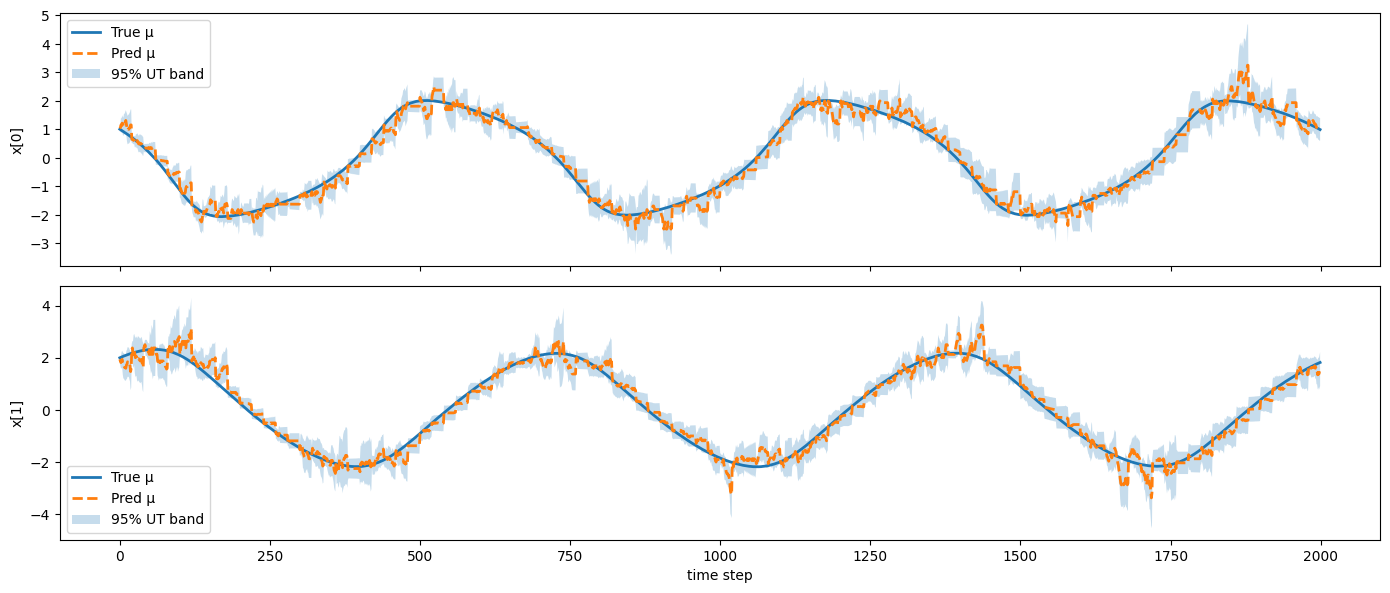

In [76]:
# --- Align time lengths BEFORE flattening ---

pred_mu  = test_outputs['mu0']           # [B, Tp, nx] (likely Tp = Tt + 1)
pred_var = test_outputs['var0']          # [B, Tp, nx]
true_mu  = test_batch['mu']              # [B, Tt, nx]
X        = test_batch['X']               # [B, Tt, nx, E]

Bp, Tp, nx = pred_mu.shape
Bt, Tt, _  = true_mu.shape
B = min(Bp, Bt)

if Tp == Tt + 1:
    # Drop the initial step from predictions so they line up with truth
    pred_mu_use  = pred_mu[:B, 1:, :]            # [B, Tt, nx]
    pred_var_use = pred_var[:B, 1:, :]           # [B, Tt, nx]
    true_mu_use  = true_mu[:B, :, :]             # [B, Tt, nx]
    X_use        = X[:B, :, :, :]                # [B, Tt, nx, E]
else:
    # Fallback: use the common min length
    Tuse = min(Tp, Tt)
    pred_mu_use  = pred_mu[:B, :Tuse, :]
    pred_var_use = pred_var[:B, :Tuse, :]
    true_mu_use  = true_mu[:B, :Tuse, :]
    X_use        = X[:B, :Tuse, :, :]

# --- Bands (state-wise 95%) ---
std     = torch.sqrt(pred_var_use.clamp_min(1e-12))
band_lo = pred_mu_use - 1.96 * std   # [B, T, nx]
band_hi = pred_mu_use + 1.96 * std

# --- Flatten windows in time order (since shuffle=False) ---
# shapes become [nx, B*T]
mu_pred = pred_mu_use.detach().cpu().numpy().reshape(-1, nx).T
mu_true = true_mu_use.detach().cpu().numpy().reshape(-1, nx).T
lo_flat = band_lo.detach().cpu().numpy().reshape(-1, nx).T
hi_flat = band_hi.detach().cpu().numpy().reshape(-1, nx).T

# --- Coverage using particles vs bands (now same length) ---
X_np   = X_use.detach().cpu().numpy()                                 # [B,T,nx,E]
X_flat = X_np.reshape(-1, X_np.shape[2], X_np.shape[3]).transpose(1,0,2)  # [nx, B*T, E]

inside   = (X_flat >= lo_flat[:, :, None]) & (X_flat <= hi_flat[:, :, None])
coverage = inside.mean()
print(f"Ensemble coverage inside 95% UT band: {coverage*100:.2f}%")

# --- Plot with bands ---
import matplotlib.pyplot as plt
nx_, Ttot = mu_pred.shape[0], mu_pred.shape[1]
fig, axes = plt.subplots(nx_, 1, figsize=(14, 3*nx_), sharex=True)
axes = [axes] if nx_ == 1 else axes
for i, ax in enumerate(axes):
    ax.plot(mu_true[i], lw=2, label='True μ')
    ax.plot(mu_pred[i], '--', lw=2, label='Pred μ')
    ax.fill_between(range(Ttot), lo_flat[i], hi_flat[i], alpha=0.25, label='95% UT band')
    ax.set_ylabel(f'x[{i}]'); ax.legend(loc='best')
axes[-1].set_xlabel('time step')
plt.tight_layout(); plt.show()
